<a href="https://colab.research.google.com/github/nlee98/ADS-505-Business-Analytics/blob/main/ADS_505_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ADS-505 Final Project
By Group 2 - Mohammad	Mahmoudighaznavi, Nicholas Lee, and Christine	Vu

In [45]:
# Packages #
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [47]:
airline_train = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_train.csv?token=GHSAT0AAAAAABYJQDWTM4ZUBDLQJVDSGGA4YZJBGFQ"
)
airline_test = pd.read_csv(
    "https://raw.githubusercontent.com/nlee98/ADS-505-Business-Analytics/main/airline_satisfaction_test.csv?token=GHSAT0AAAAAABYJQDWSEKDNNXFK45RWJGZ4YZJBGQA"
)

In [48]:
airline_train.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [49]:
airline_test.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


# Exploratory Data Analysis (EDA)

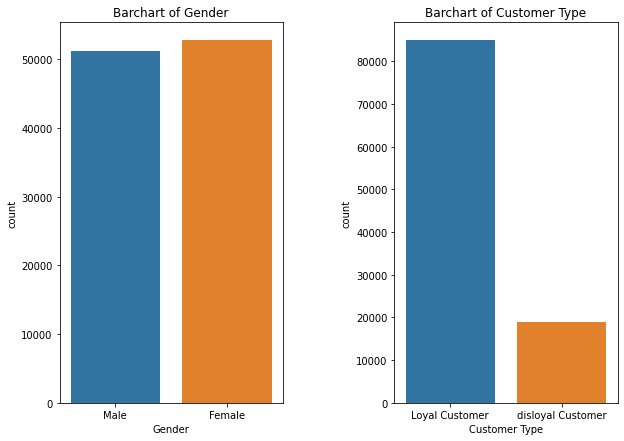

In [50]:
fig, axes = plt.subplots(
    nrows = 1,
    ncols = 2,
    figsize = (10, 7)
)

plt.subplot(1,2,1)
sns.countplot(x = airline_train["Gender"]);
plt.title("Barchart of Gender")

plt.subplot(1,2,2)
sns.countplot(x = airline_train["Customer Type"])
plt.title("Barchart of Customer Type")

fig.subplots_adjust(wspace = 0.5)
plt.show()

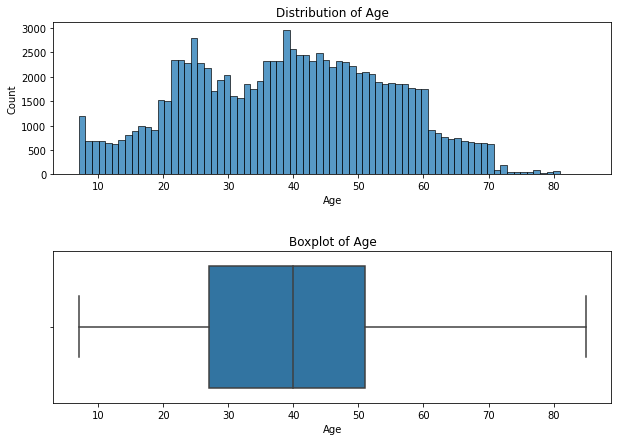

The median age is 40.0000
The average age is 39.3797


In [51]:
fig, axes = plt.subplots(
    nrows = 2,
    ncols = 1,
    figsize = (10, 7)
)

plt.subplot(2,1,1)
sns.histplot(airline_train["Age"]);
plt.title("Distribution of Age")

plt.subplot(2,1,2)
sns.boxplot(airline_train["Age"])
plt.title("Boxplot of Age")

fig.subplots_adjust(hspace = 0.5)
plt.show()

# Descriptive Statistics to Assess Normality
age_median = np.median(airline_train["Age"])
age_avg = np.average(airline_train["Age"])
print("The median age is %.4f" % age_median)
print("The average age is %.4f" % age_avg)